In [53]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#print("TensorFlow version:", tf.__version__)
#print("NumPy version:", np.__version__)

In [55]:
 # 'многокласс-класс-изображений' jupyter noutbukida danniylar bor, ya'ni rasmlar va label(klas nomlari) bor.
#Vizual transformer uchun 224X224 yoki 256X256 piksel talab etiladi
# papkadagi oldindan pikseli 224 ga o'zgartirilgan rasmlarni olamiz
train_images = np.load('resized224_train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('resized224_test_images.npy')
test_labels = np.load('test_labels.npy')
# ularni pilseli 224x224. 


In [56]:
 #Проверка формы загруженных изображений
print("Shape of loaded train_images:", train_images.shape)
print("Shape of loaded test_images:", test_images.shape)
print("Shape of loaded train_labels:", train_labels.shape)
print("Shape of loaded test_labels:", test_labels.shape)

Shape of loaded train_images: (60000, 224, 224)
Shape of loaded test_images: (10000, 224, 224)
Shape of loaded train_labels: (60000,)
Shape of loaded test_labels: (10000,)


In [59]:
# лекин 60000 та расмни ишлатиш учун мани компютеримни оператив хотираси камлик қилади.
# 60000 та расм 11 гигабайт оператив хотирани талаб қилади, маники эса максимум 8 гигабайт.
# орада бошқа вазифаларни бажаришга ҳам 2 гигабайт запас олиб қўйсак, 6 гигабайт қолади
# шуни ҳисобга олиб даннийларни яримини ишлатамиз. трейнинг учун 32700 тасини ва
# тест учун 5000 тасини оламиз.
# Загрузка данных
train_images = np.load('resized224_train_images.npy')
# Определение количества изображений для использования
# num_images_to_use = 32700  # или меньше, если хотите оставить запас, йўқ буям кўпли қилди
num_images_to_use = 15000
# Выборка нужного количества изображений
train_images_subset = train_images[:num_images_to_use]

# Теперь train_images_subset содержит 32,700 изображений

In [61]:
train_images_subset.shape

(15000, 224, 224)

In [63]:
test_images = np.load('resized224_test_images.npy')
# Определение количества изображений для тестирования
num_test_images_to_use = 2500  # или любое другое количество, которое вам нужно

# Выборка нужного количества изображений
test_images_subset = test_images[:num_test_images_to_use]

# Теперь test_images_subset содержит 5,000 изображений (или другое количество)
test_images_subset.shape

(2500, 224, 224)

In [65]:
#train_labels = np.load('train_labels.npy')
num_tr_label_to_use = 15000
# Выборка нужного количества изображений
train_labels_subset = train_labels[:num_tr_label_to_use]
train_labels_subset.shape

(15000,)

In [67]:
num_test_label_to_use = 2500
# Выборка нужного количества изображений
test_labels_subset = test_labels[:num_test_label_to_use]
test_labels_subset.shape

(2500,)

In [69]:
# Если изображения имеют форму (N, H, W), добавьте размерность для каналов тестовых данных
if test_images_subset.ndim == 3:  # Если форма (N, H, W)
    test_images_subset = np.expand_dims(test_images_subset, axis=-1)  # Добавляем размерность для каналов

test_images_subset.shape

(2500, 224, 224, 1)

In [71]:
# добавим канал и для трейнинговых фото
if train_images_subset.ndim == 3:  # Если форма (N, H, W)
    train_images_subset = np.expand_dims(train_images_subset, axis=-1)  # Добавляем размерность для каналов

train_images_subset.shape

(15000, 224, 224, 1)

In [73]:
# Нормализация значений пикселей
# Приведение значений к диапазону [0, 1]

test_images_subset = test_images_subset.astype(np.float32) / 255.0

In [75]:
train_images_subset = train_images_subset.astype(np.float32) / 255.0

In [77]:
# Примерные размеры данных
num_classes = 10  # Замените на количество классов в вашей задаче
input_shape = (224, 224, 3)  # Размер изображений, 
    #224: это высота изображения в пикселях.
    #224: это ширина изображения в пикселях.
    #3: это количество каналов  изображения.



In [79]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
# Создание модели визуального трансформера с черно-белым изображением
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Простой блок трансформера
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs) # 2 o'lchamli (2D) свёрточный слой, 
                                # извлекать пространственные признаки
                                # из входных изображений. Видеолар учун 3Д лиси ишлатилади. 
                                #32 та фильтр(ядро) кириш даннийларидан
                                #32 хил турли белгиларни олишга обучатся килинади. Мураккаб 
                                # бўлмаган расмлар учун 32 хилдаги белгиларга аҳамият бериш 
                               # етарли ҳисобланади. Видео ёки мураккаб объектлар учун кўпроқ 
                               # сондагилари олинади. Bu filtrlar rasmlarni 
                                # 3*3 pikseldagi oblastini ko'rib chiqadi (купчиликни практикасида именно 3 га 3 лиги 
                                # яхши иш берган).
                                # padding='same': Этот параметр определяет, как обрабатывать 
                                  #границы изображения. Значение 'same' означает, 
                                  #что выходное изображение будет иметь ту же ширину 
                                  #и высоту, что и входное изображение. Это достигается 
                                  #добавлением нулей (паддинга) вокруг границ входного изображения.
                                  # oxirida (input) deyilgani shu svyortochniy sloy inputga tadbiq 
                                 # qilinishini , В данном случае inputs — это тензор, 
                                 #представляющий входное изображение
                                # Таким образом, эта строка кода создает свёрточный слой, 
                               #который будет извлекать 32 различных признака из входного
                                #изображения с помощью фильтров размером 3x3, применяя 
                                #паддинг для сохранения размерности и функцию активации ReLU для нелинейности.
    x = layers.MaxPooling2D((2, 2))(x) # слой подвыборки, уменьшает размерность данных и 
                               # помогает извлекать более абстрактные признаки в 2*2 пикселях.
                               # MaxPooling кшпинча свёрточний слойлардан кейин ишл-ди, мақсад:
                               # катта даннийларни ўлчамини ихчамлаштириб, энг керакли жойларини олиш.
                               # Бу эса моделни ўқитишда ҳисоблашга кетадиган затраталарни камайтиради.
    x = layers.Flatten()(x) # kirish danniylarini 1 o'lchamli vektorga aylantiradi

    # Полносвязный слой
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [81]:
# Создание модели
#model = create_vit_model(input_shape, num_classes)
model = create_vit_model((224, 224, 1), num_classes)  # Изменено на 1 канал

In [83]:
# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [85]:
# Обзор модели
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,381,962 (196.01 MB)

 Trainable params: 51,381,962 (196.01 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# у nас есть метки для обучающих данных  train_labels = np.load('train_labels.npy')  

# Обучение модели
model.fit(train_images_subset, train_labels_subset, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.7000 - loss: 1.5365 - val_accuracy: 0.8473 - val_loss: 0.4235
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 365s 973ms/step - accuracy: 0.8609 - loss: 0.3881 - val_accuracy: 0.8590 - val_loss: 0.3813
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 360s 960ms/step - accuracy: 0.8926 - loss: 0.3018 - val_accuracy: 0.8653 - val_loss: 0.3737
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 365s 973ms/step - accuracy: 0.9175 - loss: 0.2395 - val_accuracy: 0.8667 - val_loss: 0.3562
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 368s 982ms/step - accuracy: 0.9333 - loss: 0.1859 - val_accuracy: 0.8557 - val_loss: 0.3877
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 373s 995ms/step - accuracy: 0.9446 - loss: 0.1574 - val_accuracy: 0.8643 - val_loss: 0.3757
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.9584 - loss: 0.1189 - val_accuracy: 0.8693 - val_loss: 0.4252
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.9709 - loss: 0.

In [89]:
test_images_subset.shape

(2500, 224, 224, 1)

In [91]:
test_labels_subset.shape

(2500,)

In [93]:
# Оценка модели
test_loss, test_accuracy = model.evaluate(test_images_subset, test_labels_subset)
print(f'Test accuracy: {test_accuracy:.2f}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.8735 - loss: 1.0558
Test accuracy: 0.88


In [95]:
# Сохранение модели
model.save('vizual_transformer_model_27-september.keras')

In [97]:
# Endi modelni ishlatib ko'ramiz
# umumiy test danniylardan 20 ta ishlatilmagan oxirgisini olamiz
#papkada bor:
test_images.shape

(10000, 224, 224)

In [99]:
10000-20

9980

In [101]:
# Определение количества изображений для использования
num_images_to_ishlatishga = 20  # или любое другое количество, которое вам нужно

# Выборка нужного количества изображений
sinov = test_images[9980:]
sinov.shape

(20, 224, 224)

In [103]:
# kanal qo'shamiz
sinov = np.expand_dims(sinov, axis=-1)  # Добавляем размерность для каналов

sinov.shape

(20, 224, 224, 1)

In [105]:
# normallashtirish
# Приведение значений к диапазону [0, 1]

sinov = sinov.astype(np.float32) / 255.0

In [107]:
# Получение предсказаний
predictions = model.predict(sinov)

# Если у вас несколько классов, вы можете получить класс с наибольшей вероятностью
predicted_class = np.argmax(predictions, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [109]:
predicted_class

array([0, 0, 8, 1, 3, 3, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5],
      dtype=int64)

In [111]:
import matplotlib.pyplot as plt

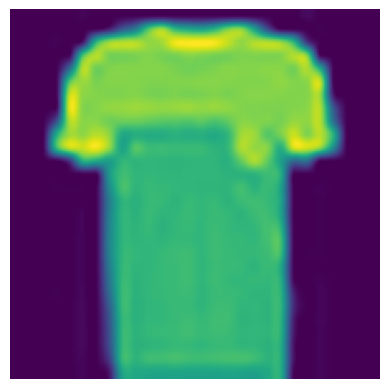

In [139]:
# Предполагаем, что img_array имеет форму (1, height, width, channels)
# Удаляем размерность батча, чтобы получить (height, width, channels)
sinov = np.squeeze(sinov)

# Отображение изображения
plt.imshow(sinov[0])
plt.axis('off')  # Отключение осей
plt.show()

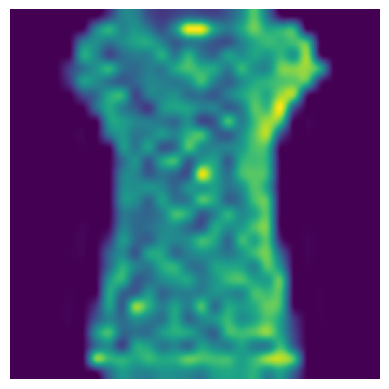

In [137]:
single_image= sinov[1]
# Отображение изображения
plt.imshow(single_image)
plt.axis('off')  # Отключение осей
plt.show()

In [ ]:
# to'g'ri ishladi